# Exploration of US healthcare spend
# Data exploration

### Introduction

Few issues in the United States stir up as much emotion, controversy, and debate as US healthcare. Hailed as one of the best in the world it is also derided for its high costs.  We propose to conduct a high level exploration of US healthcare spend on two issues concerning healthcare costs:

> 1) One of the common perceptions about the rise in US healthcare costs is concerning the role of Medicare, the federal health insurance for people 65 or older and people with disabilities. Often the perception is that when Medicare pays less for a procdure, the hospital must raise the costs for thrid party insurers to make up the difference.  Is this true?  What is the correlation, if any, between Medicare payments and overall payments for medical procedures?

> 2) Politicians are often reluctant to address healthcare costs not just because of how it persnally affects every citizen, but also because the healthcare sector as a whole often represents big business and one of the largest employers in their district.  Could political lobbying be an influencer?  What is the correlation, if any, of lobbying spend and overall charges and payment for healthcare?

The goal was explore historic data on US healthcare costs and healthcare lobbying funding and determine if there were any correlations to the data using the Pearson correlation coefficient.

In this section we take a closer look at any trends and correlations between lobbying medicare and health care spend.

## For data cleaning, please see Data notebook 

## Import tools  and data

In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
import time
import ipywidgets as widget
import string

from sklearn.linear_model import LinearRegression

In [2]:
# READ in lobby data, l_data
l_data = pd.read_csv('./data/cleaned/lobby_data.csv')
l_data.head(2)

,year,AKamount,AKper_cap,ALamount,ALper_cap,ARamount,ARper_cap,AZamount,AZper_cap,CAamount,...,WAper_cap,WIamount,WIper_cap,WVamount,WVper_cap,WYamount,WYper_cap,US_total$lobbied,US_median$bystate,US_median$percap
0,1999,0.0,0.00000,360000.0,0.075318,380000.0,0.130319,855000.0,0.133761,10597700.0,...,0.212850,1212700.0,0.213241,70000.0,0.037777,0.0,0.0,137272630.0,638000.0,0.137462
1,2000,40000.0,0.05632,500000.0,0.104608,1310000.0,0.449258,200000.0,0.031289,11241400.0,...,0.370388,932734.0,0.164012,130000.0,0.070157,0.0,0.0,160337119.0,906367.0,0.183723


In [3]:
# READ in cost data, c_data
c_data = pd.read_csv('./data/cleaned/cost_data.csv')
c_data.head(2)

,year,AK039,AK064,AK065,AK066,AK101,AK176,AK177,AK189,AK190,...,812_alls,853_alls,870_alls,871_alls,872_alls,885_alls,897_alls,917_alls,918_alls,948_alls
0,patients_2011,23.00,22.50,17.5,18.000,19.500,26.00,14.500,18.00,21.00,...,27.50,23.500,18.000,66.0000,33.50,97.000,21.0000,17.00,18.00,21.00
1,charged_2011,34805.13,42453.81,32821.0,25238.105,23156.085,35672.65,61224.635,46478.27,38283.97,...,15453.66,109708.325,127612.695,33980.3375,21764.87,15811.635,13784.1075,30302.72,13517.33,14452.81


In [4]:
# Additional data 
my_years1 = list(range(2011,2018)) # range for inpatient charges
my_years2 = list(range(1999,2020)) # range for LDA reports
my_states = ['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI',
       'MN', 'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV',
       'NY', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT',
       'VA', 'VT', 'WA', 'WI', 'WV', 'WY']
common_diagnoses = ['039', '057', '064', '065', '066', '069', '074', '101', '176',
       '177', '178', '189', '190', '191', '192', '193', '194', '195',
       '202', '207', '208', '243', '244', '246', '247', '251', '252',
       '253', '254', '280', '281', '282', '286', '287', '291', '292',
       '293', '300', '303', '305', '308', '309', '310', '312', '313',
       '314', '315', '329', '330', '372', '377', '378', '379', '389',
       '390', '391', '392', '394', '418', '439', '460', '469', '470',
       '473', '480', '481', '482', '536', '552', '563', '602', '603',
       '638', '640', '641', '682', '683', '684', '689', '690', '698',
       '699', '811', '812', '853', '870', '871', '872', '885', '897',
       '917', '918', '948']

##   
##  1. Explore and investigate correlation between how much is paid by Medicare and how much is paid by all providers

Recap: One of the common perceptions about the rise in US healthcare costs is concerning the role of Medicare, the federal health insurance for people 65 or older and people with disabilities. Often the perception is that when Medicare pays less for a procdure, the hospital must raise the costs for thrid party insurers to make up the difference. Is this true? What is the correlation, if any, between Medicare payments and overall payments for medical procedures?

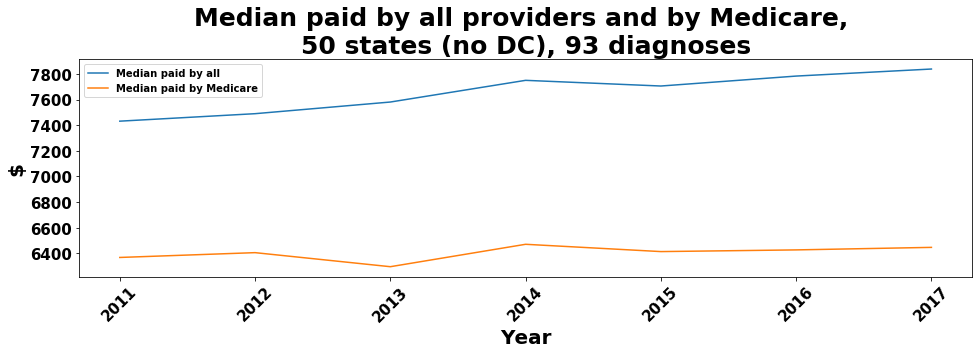

In [5]:
# PLOT US healthcare payments over time, 50 states, 93 diagnoses
plt.figure(figsize=(16,4))
plt.title('Median paid by all providers and by Medicare, \n50 states (no DC), 93 diagnoses', fontsize = 25)
#plt.plot(my_years1, c_data[c_data.year.str.contains("charged")]['USall']  , label = 'Median charged by hospitals, 50 states, 93 diagnoses')
plt.plot(my_years1, c_data[c_data.year.str.contains("byall")]['USall'], label = 'Median paid by all')
plt.plot(my_years1, c_data[c_data.year.str.contains("bymed")]['USall'], label = 'Median paid by Medicare')
plt.xlabel('Year',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(my_years1,fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.legend(loc='best');

In [6]:
# CORRELATION between what is paid by Medicare and what is paid by all providers
x = c_data[c_data.year.str.contains("byall")]['USall']
y = c_data[c_data.year.str.contains("bymed")]['USall']
scipy.stats.pearsonr(x, y)

# personr returns the Pearson Correlation and its p-value.
#The p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson corr at least 
#as extreme as the one computed from these datasets. The p-values are not entirely reliable but are probably reasonable for datasets larger than 500 or so.

(0.6238128288078792, 0.1343761207827625)

> ### OBSERVATION
> For roughly 3,000 facilities across 50 US states and for 93 common diagnoses, there is a positive correlation of **0.624** between what is paid by Medicare and what is paid by all prividers.  This indicates that the amount paid by Medicare and by all providers moves 'in sync' .

> Let's see how this correlation looks across individual US states.


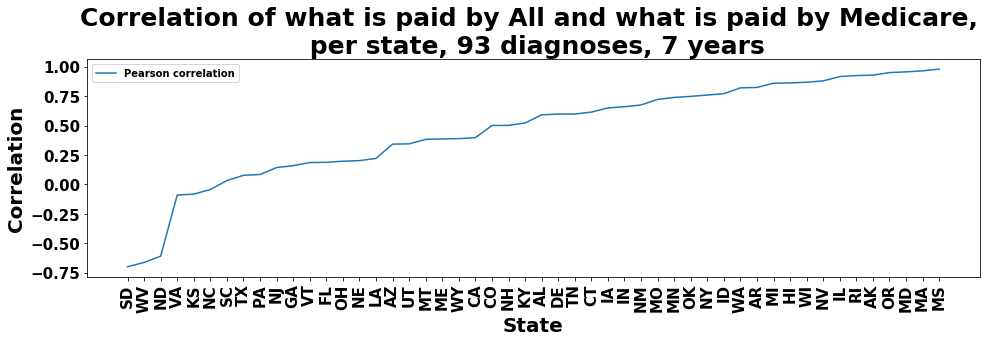

In [7]:
# calculate Pearson correlation paid by all, vs paid by Medicare, per state
pc = {}
for st in my_states:
    x = c_data[c_data.year.str.contains("byall")][f'{st}_alld']
    y = c_data[c_data.year.str.contains("bymed")][f'{st}_alld']
    pc[st] = scipy.stats.pearsonr(x, y)[0]
pc = pd.DataFrame([pc]).T
pc.sort_values(by=0, inplace=True)

# PLOT correlation
plt.figure(figsize=(16,4))
plt.title('Correlation of what is paid by All and what is paid by Medicare, \n per state, 93 diagnoses, 7 years', fontsize = 25)
plt.plot(pc[0], label = 'Pearson correlation')
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');

> ### OBSERVATION

> - Across 7 years and 93 common diagnoses, most US states have positive correlation between what is paid by Medicare and what is paid by all providers.  
> - South Dakota, North Dakota, West Virginia have strong negative correlations, meaning the amounts paid by Medicare and third parties are not in sync and go in opposing directions

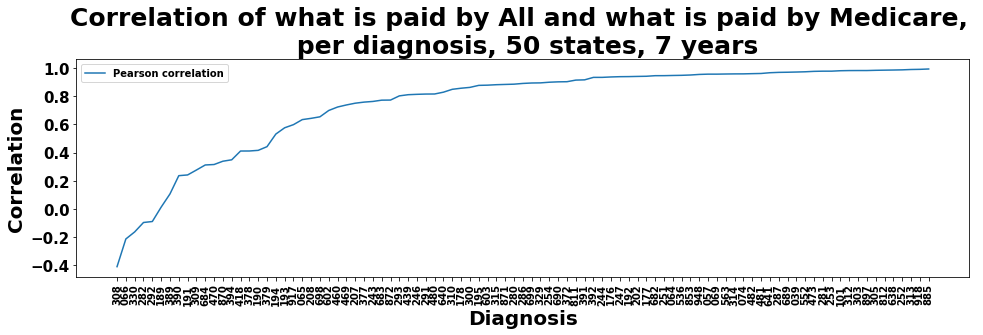

In [8]:
# calculate Pearson correlation for diagnoses
pc = {}
for di in common_diagnoses:
    x = c_data[c_data.year.str.contains("byall")][f'{di}_alls']
    y = c_data[c_data.year.str.contains("bymed")][f'{di}_alls']
    pc[di] = scipy.stats.pearsonr(x, y)[0]   
pc = pd.DataFrame([pc]).T
pc.sort_values(by=[0], inplace=True)

# PLOT correlation
plt.figure(figsize=(16,4))
plt.title('Correlation of what is paid by All and what is paid by Medicare, \n per diagnosis, 50 states, 7 years', fontsize = 25)
plt.plot(pc[0], label = 'Pearson correlation')
plt.xlabel('Diagnosis',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


> ### OBSERVATION

> Across 7 years and 50 states, most diagnoses have positive correlation between what is paid by Medicare and what is paid by all.  

> The following DRGs have negative correlations: 
- 308 : CARDIAC ARRHYTHMIA AND CONDUCTION DISORDERS WITH MAJOR COMPLICATION OR COMORBIDITY (MCC)
- 066 : INTRACRANIAL HEMORRHAGE OR CEREBRAL INFARCTION WITHOUT COMPLICATION OR COMORBIDITY (CC)/MAJOR COMPLICATION OR COMORBIDITY (MCC) 
- 330 : MAJOR SMALL & LARGE BOWEL PROCEDURES W CC
- 282 : ACUTE MYOCARDIAL INFARCTION, DISCHARGED ALIVE W/O CC/MCC
- 292 : HEART FAILURE & SHOCK W CC
- 189 : PULMONARY EDEMA AND RESPIRATORY FAILURE

> Is there a reason for these few diagnoses to have negative correlation?  Do states have too many or too few of these diagnoses?

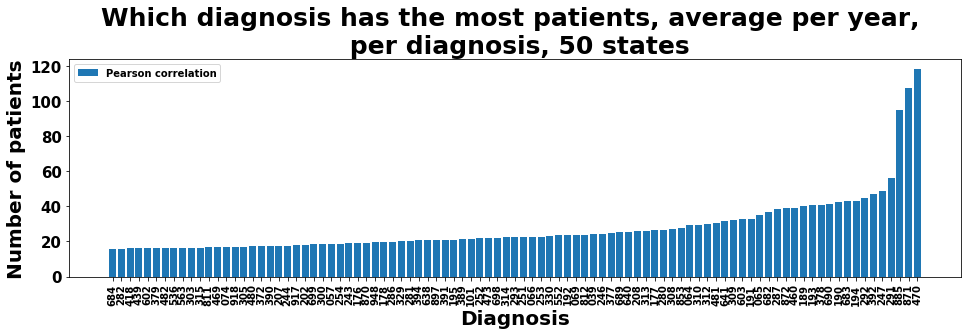

In [9]:
# PLOT which diagnosis is the most common/ has the most patients
x = []
for di in common_diagnoses:
    x.append([di , c_data[c_data.year.str.contains("patient")][f'{di}_alls'].mean()])

x = pd.DataFrame(x, columns = ['diagnosis', 'no_patients'])
x.sort_values( by = 'no_patients', inplace = True)

plt.figure(figsize=(16,4))
plt.title('Which diagnosis has the most patients, average per year, \n per diagnosis, 50 states', fontsize = 25)
plt.bar(x.diagnosis, x.no_patients , label = 'Pearson correlation')
plt.xlabel('Diagnosis',fontsize=20)
plt.ylabel('Number of patients',fontsize=20)
plt.xticks(fontsize=10, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');

> ### OBSERVATION

> There is not observable trend in terms of volume of procedure and charge.

###   
## 2. Explore and investigate correlation between how much hospitals charge for diagnoses vs how much is lobbied

Recap: Politicians are often reluctant to address healthcare costs not just because of how it persnally affects every citizen, but also because the healthcare sector as a whole often represents big business and one of the largest employers in their district. Could political lobbying be an influencer? What is the correlation, if any, of lobbying spend and overall charges and payment for healthcare?

2011-2017 Lobbying line beta = 6769852.321429053, intercept = -13210292841.50097
1999-2019 Lobbying line beta = 18612342.711688325, intercept = -37065105738.49613


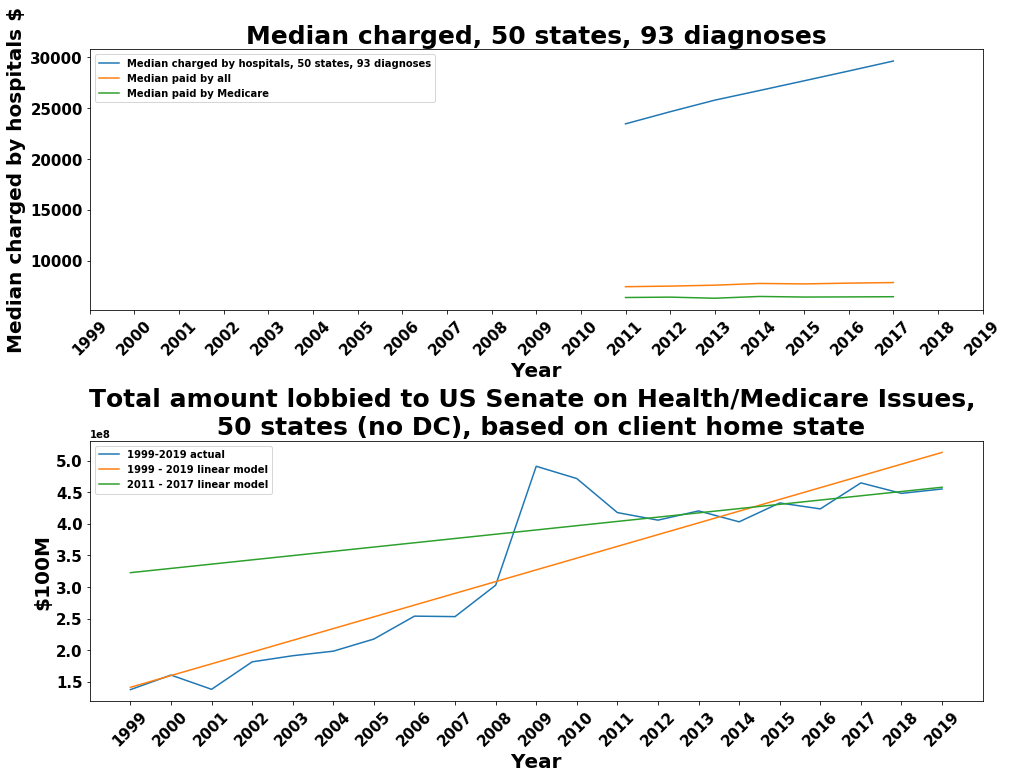

In [10]:
# PLOT Correlation between how much hospitals charge for diagnoese vs how much is lobbied in health and Medicare issues

plt.figure(figsize=(16,12)) 
plt.subplots_adjust(hspace=0.5)

# SUBPLOT US healthcare charges/payments over time, 50 states, 93 diagnoses
plt.subplot(2, 1, 1) 
plt.title('Median charged, 50 states, 93 diagnoses', fontsize = 25)
plt.plot(my_years1, c_data[c_data.year.str.contains("charged")]['USall']  , label = 'Median charged by hospitals, 50 states, 93 diagnoses')
plt.plot(my_years1, c_data[c_data.year.str.contains("byall")]['USall'], label = 'Median paid by all')
plt.plot(my_years1, c_data[c_data.year.str.contains("bymed")]['USall'], label = 'Median paid by Medicare')
plt.xlabel('Year',fontsize=20)
plt.ylabel('Median charged by hospitals $',fontsize=20)
plt.xticks(my_years2,fontsize=15, rotation = 45)
plt.xlim(1999,2019)
plt.yticks(fontsize=15)
plt.legend(loc='best')


# Linear regression for 1999-2019 lobbying
lobby_linreg1 = np.polyfit(l_data.year, l_data['US_total$lobbied'] , 1)

# linear regression for 2011 - 2017 lobbying
lobby_linreg2 = np.polyfit(l_data.year[l_data.year.between(2011, 2017)],
                           l_data[l_data.year.between(2011, 2017)]['US_total$lobbied'] , 1)

# SUBPLOT total amount lobbied to US Senate for Health Issues, 1999-2019
# Comment - big spike in 2009 and 2010 probably due to reaction to Obamacare
plt.subplot(2,1,2)
plt.title('Total amount lobbied to US Senate on Health/Medicare Issues, \n 50 states (no DC), based on client home state', fontsize = 25)
plt.plot(l_data.year , l_data['US_total$lobbied'], label = '1999-2019 actual')
plt.plot(l_data.year , lobby_linreg1[0]*l_data.year + lobby_linreg1[1], label = '1999 - 2019 linear model')
plt.plot(my_years2 , lobby_linreg2[0]*l_data.year + lobby_linreg2[1], label = '2011 - 2017 linear model') 
plt.xlabel('Year',fontsize=20)
plt.ylabel('$100M',fontsize=20)
plt.xticks(l_data.year,fontsize=15, rotation = 45)
plt.yticks(fontsize=15)
plt.legend(loc='best');

print(f'2011-2017 Lobbying line beta = {lobby_linreg2[0]}, intercept = {lobby_linreg2[1]}')
print(f'1999-2019 Lobbying line beta = {lobby_linreg1[0]}, intercept = {lobby_linreg1[1]}')

In [11]:
# CORRELATION of US Lobbying vs what is charged by hospitals, 50 states, 93 diagnoses, 2011 - 2017
x = c_data[c_data.year.str.contains("charged")]['USall']
y = l_data[l_data.year.between(2011, 2017)]['US_total$lobbied']
scipy.stats.pearsonr(x, y)

(0.6902768303608628, 0.0860489124201961)

In [12]:
# CORRELATION of US Lobbying vs what is charged by hospitals, 50 states, 93 diagnoses, using 1999-2019 linear model
x = c_data[c_data.year.str.contains("charged")]['USall']
# lobby data generated from linear model
y = []
for yr in my_years1:
    y.append(lobby_linreg2[0]*yr + lobby_linreg2[1])
scipy.stats.pearsonr(x, y)

(0.999003691273143, 6.014601215257246e-08)

> ### OBSERVATION 

> For the given data there is a positive correlation of **0.690** between what is lobbied for health and Medicare issues and the amount hospitals charge for diagnoses.  This means that from 2011 - 2017 for 50 US states and 93 common diagnoses, the amount hospitals charge for these diagnoses is 'in sync' with what is lobbied, i.e. all are rising with time.

> BUT taken historical lobbying data from 1999 - 2019 into account, there is a a strong positve correlation of **0.999** between what is lobbied for health and Medicare issues and the amount hospitals charge for diagnoses.

> Can this positive correlation be mapped on the the state level?

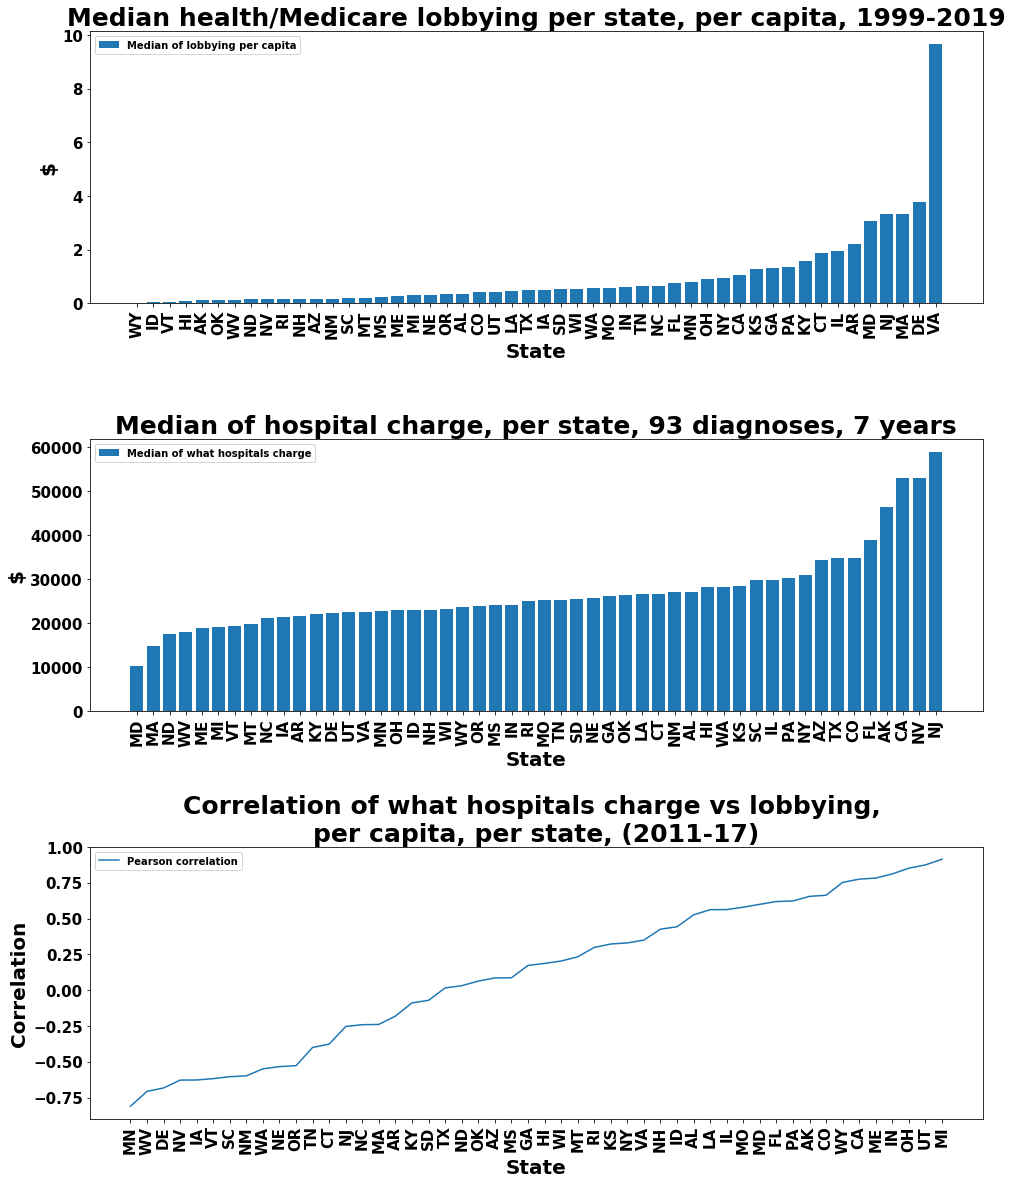

In [13]:
# PLOT correlation of ser capita lobbying vs amount hospitals charge for diagnoses

plt.figure(figsize=(16,20)) 
plt.subplots_adjust(hspace=0.5)

# PLOT US healthcare charges/payments over time, 50 states, 93 diagnoses
plt.subplot(3, 1, 1) 
x1=[]
for st in my_states:     
    x1.append([st , l_data[f'{st}per_cap'].median()])
    
    #y = l_data[l_data['year'].between(2011, 2017)][f'{st}per_cap']
x1= pd.DataFrame(x1, columns = ['state', 'percap'])
x1.sort_values(by = ['percap'], inplace = True)

plt.title('Median health/Medicare lobbying per state, per capita, 1999-2019', fontsize = 25)
plt.bar( x1.state, x1.percap, label = 'Median of lobbying per capita')
plt.xlabel('State',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


#PLOT total amount lobbied to US Senate for Health Issues, 1999-2019
# Comment - big spike in 2009 and 2010 probably due to reaction to Obamacare
plt.subplot(3,1,2)

x1=[]
for st in my_states:  
    x1.append([st , c_data[c_data.year.str.contains("charged")][f'{st}_alld'].mean()])
x1= pd.DataFrame(x1 , columns = ['state','charged'])
x1.sort_values(by = ['charged'], inplace = True)

#plt.figure(figsize=(16,4))
plt.title('Median of hospital charge, per state, 93 diagnoses, 7 years', fontsize = 25)
plt.bar( x1.state, x1.charged, label = 'Median of what hospitals charge')
plt.xlabel('State',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');

# PLOT correlation 
plt.subplot(3,1,3)
pc = {}
pp = {}
for st in my_states:
    x = c_data[c_data.year.str.contains("charged")][f'{st}_alld']
    y = l_data[l_data['year'].between(2011, 2017)][f'{st}per_cap']
    pc[st] = scipy.stats.pearsonr(x, y)[0]
    pp[st] = scipy.stats.pearsonr(x, y)[1]
    
corr_charge_lobby = pd.DataFrame([pc,pp]).T
corr_charge_lobby.rename(columns ={0:'corr', 1:'pvalue'}, inplace=True)
corr_charge_lobby.sort_values(by=['corr'], inplace=True)

plt.title('Correlation of what hospitals charge vs lobbying, \nper capita, per state, (2011-17)', fontsize = 25)
plt.plot(corr_charge_lobby['corr'], label = 'Pearson correlation')
plt.xlabel('State',fontsize=20)
plt.ylabel('Correlation',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


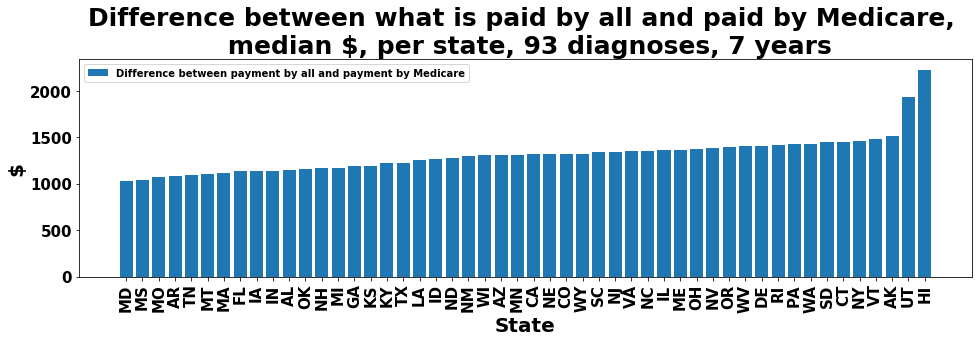

In [14]:
# PLOT which states have the largest $ difference 
# between what is paid by Medicare vs what is paid by all

payment_delta = []
for st in my_states:
    payment_delta.append([st , 
              (c_data[c_data.year.str.contains("byall")][f'{st}_alld'].mean() -
               c_data[c_data.year.str.contains("bymed")][f'{st}_alld'].mean()) 
               ])
     
payment_delta = pd.DataFrame(payment_delta, columns = ['state' ,'delta_paid_over_med'])
payment_delta.sort_values(by = ['delta_paid_over_med'], inplace = True)

plt.figure(figsize=(16,4))
plt.title('Difference between what is paid by all and paid by Medicare, \n median $, per state, 93 diagnoses, 7 years', fontsize = 25)
plt.bar( payment_delta.state, payment_delta.delta_paid_over_med, label = 'Difference between payment by all and payment by Medicare')
plt.xlabel('State',fontsize=20)
plt.ylabel('$',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');

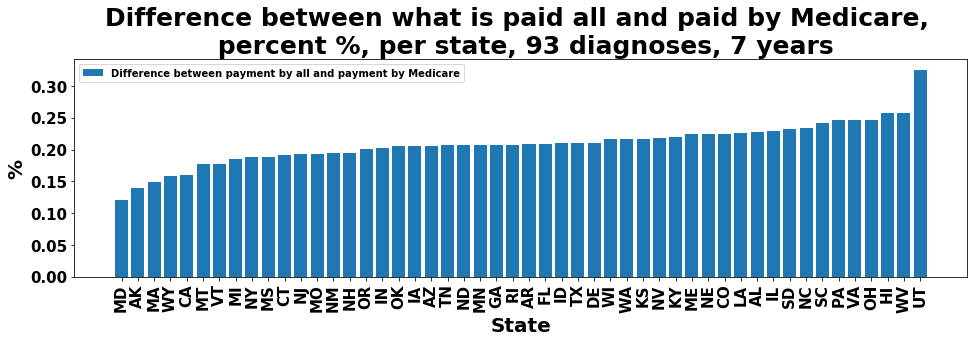

In [15]:
# PLOT which states have the largest % difference 
# between what is paid by Medicare vs what is paid by all

payment_delta = []
for st in my_states:
    payment_delta.append([st , 
              (c_data[c_data.year.str.contains("byall")][f'{st}_alld'].mean() -
               c_data[c_data.year.str.contains("bymed")][f'{st}_alld'].mean()) /
                        c_data[c_data.year.str.contains("bymed")][f'{st}_alld'].mean()
               ])   
payment_delta = pd.DataFrame(payment_delta, columns = ['state' ,'delta_paid_over_med'])
payment_delta.sort_values(by = ['delta_paid_over_med'], inplace = True)

plt.figure(figsize=(16,4))
plt.title('Difference between what is paid all and paid by Medicare, \n percent %, per state, 93 diagnoses, 7 years', fontsize = 25)
plt.bar( payment_delta.state, payment_delta.delta_paid_over_med, label = 'Difference between payment by all and payment by Medicare')
plt.xlabel('State',fontsize=20)
plt.ylabel('%',fontsize=20)
plt.xticks(fontsize=15, rotation = 90)
plt.yticks(fontsize=15)
plt.legend(loc='best');


> ### OBSERVATION

> There is very high variability in the data and there is no discernable correlation between health charges and lobbying on a state level.